# GAN: Generative Adversarial Network - a first example

Este código foi extraído da página de [Jason Brownlee](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) 
Fiz algumas modificações e correções em algumas linhas de código. 

Será o primeiro exemplo, bem simples, de uma GAN usando a API Sequential para criar novas imagens de dígitos similares àqueles do dataset MNIST.Vamos começar com este dataset bem simples para que o modelo seja pequeno e possa ser treinado rapidamente, nos permitindo concentrar na arquitetura do modelo e no próprio processo de geração de imagem.

Comece escolhendo a opção "GPU" no menu drop-down do ambiente de execução. Clique em "Alterar o ambiente de execução"  e escolha a opção "GPU" em "Acelerador de software". Caso contrário, o notebook vai demorar bastante mesmo neste problema pequeno.

In [ ]:
# importando as bibliotecas necessárias 
import numpy as np
from numpy import expand_dims
from numpy import zeros, ones
from numpy import vstack
from numpy.random import uniform, randn, randint

from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam 
# from keras.optimizers import Adam # estava no original e não funciona
from keras.models import Sequential

from keras.layers import Dense, Reshape, Flatten, Conv2D 
from keras.layers import Conv2DTranspose, LeakyReLU, Dropout

from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt 

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


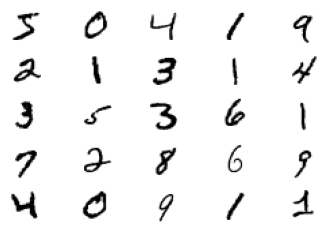

(28, 28)


In [ ]:
# Carregando os dados do MNIST

(trainX, trainy), (testX, testy) = load_data()

# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

# plote as 25 primeiras imagens do conjunto de treinamento 
for i in range(25):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
  # usar cores em tons de cinza revertidas: 0=branco e 255=preto
	plt.imshow(trainX[i], cmap='gray_r') 
plt.show()

print(np.shape(trainX[i])) # outputs (28, 28)

# Definindo o discriminador.

O discriminador deve receber uma imagem como entrada. Esta entrada por de ser uma imagem que realmnete pertence ao nosso conjunto de treinamento ou pode ser uma imagem falsa produzida pelo gerador, ainda a ser definido. Como saída, o discriminador deve produzir uma previsão de classificação: se a imagem na entrada é real ou falsa. 

O discriminador é uma rede neural com duas camadas convolucionais, ambas com  64 filtros. Cada filtro será do tipo 3x3 com stride=2 e padding garantindo uma saída de mesma dimensão que a entrada. O modelo não tem camadas de pooling. Ele terá um único nó na camada de saída com a função de ativação sigmóide para prever se o a amostra de entrada é real ou falsa. O modelo é treinado para minimizar a função de perda de entropia cruzada binária, apropriada para classificação binária.

Usaremos algumas práticas recomendadas na definição do discriminador, como o uso de LeakyReLU em vez de ReLU, usando Dropout e usando a versão Adam da descida gradiente estocástica com uma taxa de aprendizagem de 0.0002 e um momentum de 0.5.

A função define_discriminator () abaixo define o modelo discriminador e parametriza o tamanho da imagem de entrada.

In [ ]:
# specifying the discriminator neural network model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_14 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 dropout_15 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 flatten_7 (Flatten)         (None, 3136)            

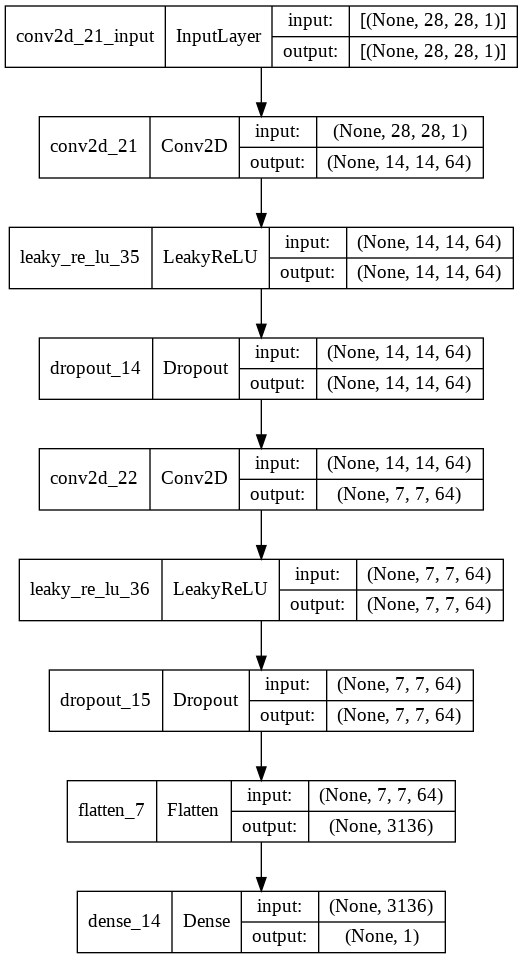

In [ ]:
# vamos instanciar um modelo que terá apenas o discriminator (por enquanto) 
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

O stride 2x2 reduz bastante os dados da entrada. Primeiro, ele vai da entrada 28 × 28 para 14 × 14, e depois para 7 × 7. Só então os 64 filtros 7x7 são achatados num array uni-dimensional 3136=7*7*64. Poderíamos trocar o stride pela operação de max-pooling para obter o mesmo efeito de redução da informação. 

In [ ]:
# The images are 2D arrays of pixels and CNNs expect 
# 3D arrays of images as input, where each image has one or more channels.
# Create a function to load and prepare mnist training images as 3D arrays
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

In [ ]:
# Mais tarde faremos uso desta função para carregar e preparar o MNIST ao treinar a GAN
# Veja o resultado de invocar a função acima
dataset = load_real_samples()
print(type(dataset))
print(np.shape(dataset))
print(dataset.shape[0])

<class 'numpy.ndarray'>
(60000, 28, 28, 1)
60000


É boa prática permutar aleatoriamente os dados da amostra de treinamento pois elas podem ter sido ordenadas de alguma forma relacionada com o seu conteúdo. Um cuidado adicional é fazer esta permutação aleatória antes de cada época pois com isto criamos mais diversaidade nos batches. Uma abordagem mais simples é selecionar amostras aleatórias de imagens do conjunto de dados de treinamento.

A função generate_real_samples () abaixo tomará o conjunto de dados de treinamento como um argumento e selecionará uma subamostra aleatória de imagens; ele também retornará rótulos de classe para o exemplo, especificamente um rótulo de classe de 1, para indicar imagens reais.

In [ ]:
# select real samples from a dataset
def generate_real_samples(dataset, n_samples):
	# seleciona exemplos ao acaso: 
	# randint seleciona n_samples (com reposição) entre os inteiros 0 e o 2o arg
	# 2o arg = (60000-1) se dataset é a saída de load_real_samples()  
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [ ]:
# Exemplo de uso da função acima
dataset = load_real_samples()
Xlixo, ylixo = generate_real_samples(dataset, 5)
print(type(Xlixo))
print(np.shape(Xlixo))

<class 'numpy.ndarray'>
(5, 28, 28, 1)


# Um primeiro gerador de imagens falsas

Ainda não temos um modelo gerador. Em vez disso, podemos gerar imagens compostas de valores completamente aleatórios em cada pixel. É claro que estas "imagens" são puro ruído, sem nenhuma estrutura que lembre nem memos vagamente os dígitos reais no dataset MNIST. Imitando as imagens reais, os valores a serem gerados devem estar no intervalo [0,1]. 

A função generate_fake_samples () abaixo implementa esse comportamento e gera imagens de valores de pixel aleatórios e seu rótulo de classe associado de 0, para falso.

In [ ]:
# generate n fake samples with class labels = 0 (False)
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = uniform(0, 1, 28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# gere 10 imagens fake, formadas de puro ruído 
X_fake, y_fake = generate_fake_samples(10)
print('Train',X_fake.shape, y_fake.shape)

Train (10, 28, 28, 1) (10, 1)


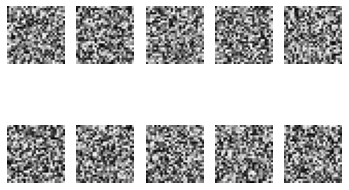

In [ ]:
# plote as 10 imagens fake geradas
for i in range(10):
	# define subplot
	plt.subplot(2, 5, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
  # usar cores em tons de cinza revertidas: 0=branco e 255=preto
	plt.imshow(X_fake[i].reshape((28, 28)), cmap='gray_r') 
plt.show()

# Treinando o discriminador com as imagens completamente aleatórias

Vamos treinar o discriminador para que ele aprenda a discriminar entre as imagens reais de dígitos do MNIST e as imagens fake completamente aleatórias definidas acima. 

Esta tarefa será muito fácil pois as imagens fake são muito diferentes das imagens reais. Lembre-se que ainda não definimos um modelo para o gerador. Portanto, as iamgens fake geradas serão sempre puro ruído e o discriminador vai aprender rapidamente a discriminar com perfeição entre as duas classes (real e fake).  

A função train_discriminator () implementa isso, usando um batch size de 256 imagens onde 128 são reais e 128 são falsas a cada iteração.

Em cada passo do loop da atualização do discriminador, atualizamos o discriminador separadamente para exemplos reais e falsos. Atualizamos o valor corrente dos pesos da rede neural do discrminador usando apenas a parte do batch composta pelas imagens reais e calculamos a porcentagem destas imagens reais que é classificada corretamente. A seguir, usamos a outra metade do batch, composta apenas de imagens fake completamente aleatórias, para atualizar os pesos do discriminador. Calculamos a acurácia usando estes dados fake: a porcentagem das imagens fake que são classiicadas como fake. O objetivo é aumentar as duas acurácias de forma a serem próximas ou iguais de 100%. A progressão desse aumento das porcentagens dá uma ideia de como o modelo discriminador está se saindo ao longo do tempo.

In [ ]:
# How to train the discriminator model 
# Using 50 epochs (n_iter=50) with batches=256
def train_discriminator(model, dataset, n_iter=50, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected real samples (images and labels)
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate fake examples (images and labels)
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real acc. =%.0f%% - fake acc.=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

train_on_batch allows you to expressly update weights based on a collection of samples you provide, without regard to any fixed batch size.

In [ ]:
# specify  model with the discriminator only
d_model = define_discriminator()
# It is the same command as before, just to make sure we have the correct model

# load the MNIST data
dataset = load_real_samples()

# fit the discriminator by calling train_discriminator
# We use MNIST and random noise as fake images
train_discriminator(d_model, dataset)

>1 real acc. =41% - fake acc.=34%
>2 real acc. =57% - fake acc.=49%
>3 real acc. =60% - fake acc.=75%
>4 real acc. =55% - fake acc.=84%
>5 real acc. =59% - fake acc.=91%
>6 real acc. =56% - fake acc.=99%
>7 real acc. =52% - fake acc.=99%
>8 real acc. =63% - fake acc.=98%
>9 real acc. =63% - fake acc.=100%
>10 real acc. =61% - fake acc.=100%
>11 real acc. =72% - fake acc.=100%
>12 real acc. =73% - fake acc.=100%
>13 real acc. =70% - fake acc.=100%
>14 real acc. =62% - fake acc.=100%
>15 real acc. =73% - fake acc.=100%
>16 real acc. =74% - fake acc.=100%
>17 real acc. =79% - fake acc.=100%
>18 real acc. =77% - fake acc.=100%
>19 real acc. =78% - fake acc.=100%
>20 real acc. =77% - fake acc.=100%
>21 real acc. =84% - fake acc.=100%
>22 real acc. =84% - fake acc.=100%
>23 real acc. =84% - fake acc.=100%
>24 real acc. =91% - fake acc.=100%
>25 real acc. =91% - fake acc.=100%
>26 real acc. =88% - fake acc.=100%
>27 real acc. =93% - fake acc.=100%
>28 real acc. =93% - fake acc.=100%
>29 real 

# Resultado de discriminar entre imagens reais e ruído

COmo vemos acima, o discriminador aprende rapidamente a separar as imagens reais das imagens fake que, neste momento, são sempre apenas as imagens de ruído completamente aleatórios. De fato, após 40 iterações aproximadamente, a acurácia é de 100% entre as imagens reais e é também de 100% entre as imagens fake. Isto é, temos um discriminador obtendo $\mathbb{P}(\text{classifica como real} | \text{é real}) = 1$ e $\mathbb{P}(\text{classifica como fake} | \text{é fake}) = 1$. 

A tarefa é fácil para o discriminador pois as imagens reais do MNIST são muito distintas das imagens fake que estão sendo geradas. Geramos apenas ruídos completamente aleatórios (valores entre 0 e 1 completamente ao acaso em cada pixel). O gerador nunca muda, sempre gera apenas imagens compostas de puros ruídos, números completamente aleatórios em cada pixel. 

O que vamos fazer agora é criar um modelo de rede neural para que o gerador possa aprender a gerar imagens fake que sejam similares às imagens reais do MNIST. Assim, o gerador vai mudando a medida em que o discriminador vai aprendendo. Ele vai tentar gerar imagens cada vez mais parecidas com as imagens reais do MNIST. 

# Definindo o gerador

O gerador é responsável por criar imagens novas e falsas, mas plausíveis, de dígitos manuscritos. Pegamos um ponto z do espaço latente como entrada e geramos uma imagem 28x28 em tons de cinza.

O espaço latente é um espaço vetorial arbitrariamente definido de valores com distribuição gaussiana. Em geral, o espaço latente é o $\mathbb{R}^n$ com uma dimensão $n$ que deve ser escolhida arbitrarimente pelo usuário. Neste problema, vamos escolher $n=100$. Um ponto $\mathbf{z}=(z_1, \ldots, z_{100}) \in \mathbb{R}^{100}$ deste espaço será selecionado ao acaso com uma distribuição gaussiana multivariada com dimensão 100 e com vetor de médias $\mathbf{0}=(0,0,...,0)$ e matriz de covariância identidade $\mathbf{I}_{100}$. Isto é, $\mathbf{z} \sim \mathcal{N}_{100}(\mathbf{0}, \mathbf{I}_{100})$.

Existe um trade-off para a escolha da dimsnsão $n$ para o espaço latente. Se ela for pequena demais, podemos terminar com um gerador que não é capaz de gerar imagens ricas como as do dataset que estamos considerando. Por outro lado, se ela for muito grande, a complexidade do modelo vai implicar numa ineficiência computacional desnecessária. As imagens do MNIST são muito simples e provavelmente $n=100$ é um valor super-dimensionado. Valores tais como $n=20$ devem ser tão bons quanto $n=100$. Entretanto, vamos deixar de lado o problema da escolha da dimensão do espaço latente e seguir usando a escolha arbitrária de $n=100$ no restante deste notebook.

A imagem a ser criada depende da região no espaço latente $\mathbb{R}^{100}$ onde o ponto aleatório $\mathbf{z}$ é selecionado. Quando o gerador aprender a gerar os dígitos do MNIST a ponto de enganar o discriminador com freqûencia, estaremos gerando 0's, 5's, ou outro dígitos dependendo do vetor aleatório $\mathbf{z}$. 

Entrada: ponto no espaço latente, por exemplo um vetor de 100 elementos de números aleatórios gaussianos.
Saída: Imagem quadrada bidimensional em tons de cinza de 28 × 28 pixels com valores de pixel em [0,1].

In [ ]:
# generate n_sample points in latent space with dimension = latent_dim
# These points will be the inputs for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# A rede neural do gerador 

O desenvolvimento de um modelo de gerador requer que transformemos um vetor $\mathbf{z}$ com 100 dimensões do espaço latente em uma matriz 2D com 28 × 28 ou 784 valores. Uma transformação bastante popular em GANs envolve dois elementos principais.

O primeiro deles é começar com uma camada Densa com nós suficientes para representar uma versão de baixa resolução da imagem de saída. Especificamente, uma imagem com metade do tamanho (um quarto da área) da imagem de saída seria 14 × 14 ou 196 nós, e uma imagem com um quarto do tamanho (um oitavo da área) seria 7 × 7 ou 49 nós.

O segundo elemento é aplicar vários filtros paralelos formando canais  resultando em múltiplos mapas de ativação, chamados "feature maps". Em seguida, fazemos upsampling para obter um array com a mesma dimensão das imagens da entrada. 

In [ ]:
# specify a neural net model for the generator 
def define_generator(latent_dim):
	model = Sequential()
	# formando uma imagem 7x7 com 128 canais
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
  # colocando o array uni-dim na forma de uma array 3-dim com 128 canais 
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model 

A função define_discriminator que usamos anteriormente compilava o modelo discriminador usando uma função de perda, um otimizador e outros parâmetros. Nesta função anterior, as últimas linhas de código são as seguintes: 

```
# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
```
Na função define_generator definida acima, estas linhas de compilação do modelo não estão presentes. Ela não especifica uma função de perda ou um algoritmo de otimização. Isso ocorre porque o gerador não é treinado diretamente. A sua função de perda é determinada pela função de perda do discriminador, sendo o seu negativo. Este será um jogo de soma zero e a perda de um dos jogadores será o ganho do outro. Voltaremos a este ponto mais a frente. 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

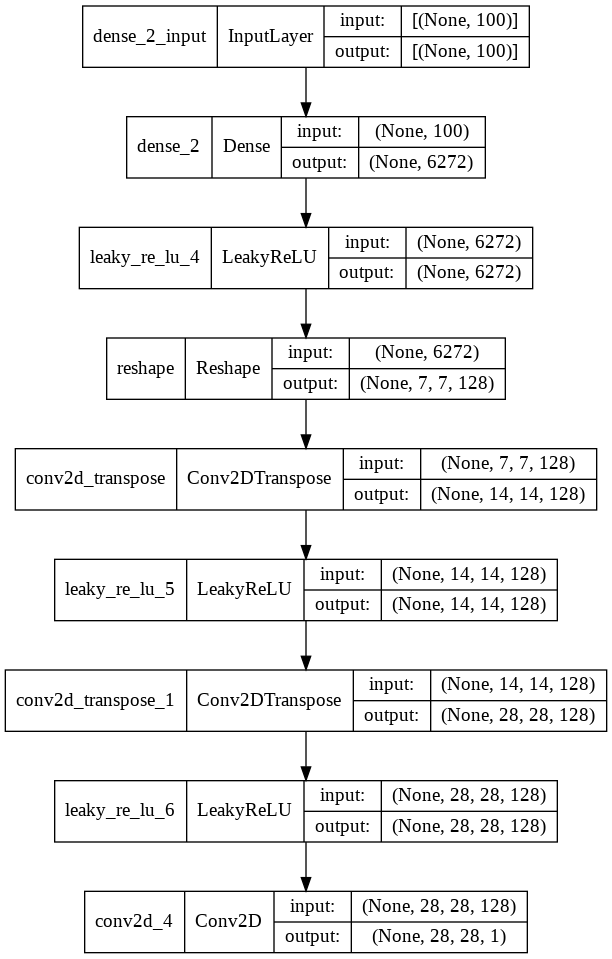

In [ ]:
# define the size of the latent space
latent_dim = 100
# instancia um object chamado g_model onde temos apenas o gerador 
g_model = define_generator(latent_dim)
# summarize the model
g_model.summary()
# plot the model
plot_model(g_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

# Do espaço latente para o output (imagens)

Tendo definido um modelo para o gerador, podemos definir agora uma função que recebe os pontos $\mathbf{z} \in \mathbb{R}^{100}$ pertencentes ao espaço latente e retorna um elemento $\mathbf{x}$ do domínio. No nosso exemplo MNIST,
$\mathbf{x}$ \'{e} uma imagem-array $(28,28, 1)$.   

A função fará uso do modelo gerador com os pesos que estiverem associados com ele. Se for usada imediatamente depois de definida, ela fará uso de pesos default, que são números aleatórios associados com cada aresta da rede. 

O output será uma imagem-array $(28,28, 1)$ obtida passando a entrada $\mathbf{z} \in \mathbb{R}^{100}$ pela rede neural de forma feedforward. Para isto, usamos o método "predict" associado com a classe Model em Keras.

In [ ]:
# use the sample points of the latent space to create n fake examples (images)
# Also, create the fake class labels to these examples
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# create an image/output by using the predict method (equiv to pass feedforwardly 
	# the x_input through the generator neural net)   
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

## Exemplificando o uso da função acima

Abaixo, vamos usar o modelo gerador para criar 25 imagens $28 \times 28$ aleatórias a partir de vetores gaussianos de dimensão 100.  

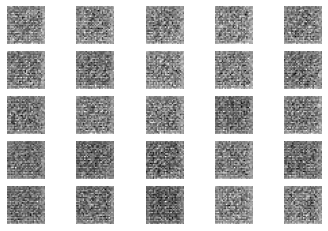

<class 'numpy.ndarray'>


(25, 28, 28, 1)

In [ ]:
# size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# number of images/samples to be generated 
n_samples = 25
# generate the images using randomly assigned weights
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis labels
	plt.axis('off')
	# plot single image
	plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.show()

print(type(X))
X.shape

## Como treinar o modelo do gerador

Os pesos no modelo do gerador são atualizados com base no desempenho do modelo discriminador. Temos um jogo de soma zero, com a perda de um jogador sendo o ganho do outro. Nós já definimos uma função de perda $L$ para o discriminador (a entropia cruzada de um classificador binário usual). Assim, automaticamente fica determinada a função de perda do gerador, que é $-L$, o negaivo da função de perda do discriminador. Isso define a relação adversária, de soma zero, entre esses dois modelos. O gerador deve atualizar seus pesos visando à minimização de sua perda. 

Para vermos isto em ação, vamos congelar o modelo do discriminador com os pesos encontrados anteriormente na tarefa fácil de discriminar entre as imagens reais e as imagens fake completamente aleatórias. Nesta situação, vimos que o discriminador faz um trabalho perfeito, seperando sem erros as imagens reais e fake. Vamos antão permitir que o gerador, e apenas o gerador, melhore. Sem que o discriminador possa atualizar os seus pesos, vamos deixar que o gerador aprenda pesos que minimizem a sua (do gerador) perda (isto é, minimizem $-L$). Isto deve piorar a acurácia do discriminador já que, ao minimizar $-L$, estaremos ao mesmo tempo aumentando $L$, a perda do discriminador. Isto quer dizer que as imagens que o gerador passa a gerar devem começar a enganar ocasionalmente o discriminador. 

Na verdade, existem muitas maneiras de implementar uma função de perda para o gerador que não seja tão simples quanto esta de jogos de soma zero, em que a perda do gerador seja o negativo da perda do dissriminador. Veremos em outros exemplos de GANs situações que justificam uma funções de perda mais complexas e como podemos usar a API Keras para defini-las. 

A função define_gan() abaixo tem como argumentos os modelos gerador e discriminador já definidos e cria um terceiro modelo lógico que inclui esses dois modelos já definidos. Os pesos no discriminador são marcados como não treináveis e portanto não poderão se atualizados. Ela usa a mesma função de perda de entropia cruzada binária usada pelo discriminador e opções default em redes CNNs (learning rate =0.0002 e momentum=0.5 com otimizador Adam). Uma coisa que não definimos ainda é que a função de perda do gerador é o negativo desta função de perda de entropia cruzada. Faremos isto depois de vermos o código abaixo. 

In [ ]:
# define the combined generator and discriminator model
# The update will be carried out ONLY on the generator network
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model with the **usual binary discriminator loss function**
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

## Criando uma instância de modelo GAN

Veja como o modelo espera imagens MNIST como entrada e prevê um único valor como saída. Um gráfico do modelo também é criado e podemos ver que o modelo espera um ponto de 100 elementos no espaço latente como entrada e irá prever um único rótulo de classificação de saída.

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_22 (Sequential)  (None, 28, 28, 1)         1164289   
                                                                 
 sequential_21 (Sequential)  (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


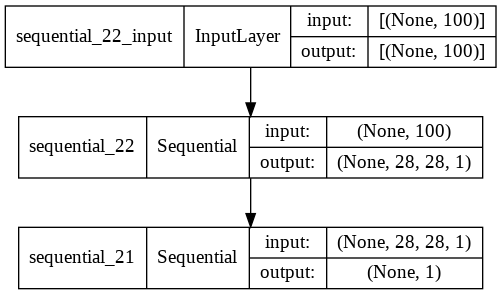

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

## Especificando a perda do gerador

Vamos usar um truque simples para definir a função de perda do gerador. Ao invés de especificá-la como sendo o negativo da função de perda do discriminador, vamos trocar os labels dos exemplos. 

Ao treinar o gerador na GAN, queremos que o discriminador pense que as amostras geradas pelo gerador são reais, não falsas. Portanto, quando o gerador for treinado como parte do modelo GAN mantendo a mesma função de entropia cruzada, marcaremos as amostras geradas como reais (classe 1) e as amostras reais como fakes (classe 0).

Vamos então treinar o modelo GAN, composto pelos modelos discriminator e generator, com a opção d_model.trainable = False. Isto é, apenas os pesos do gerador serão atualizados. Além disso, vamos trocar os labels 0 e 1.

In [ ]:
# train the composite model with d_model.trainable = False
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
	 		# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

In [ ]:
# Define the GAN model by combining the generator and discriminator model
# The generator and discriminator models are passed as input to this function
# it also defines how to update the generator weights

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


A saída de streaming foi truncada nas últimas 5000 linhas.
>9, 149/234, d=0.654, g=0.769
>9, 150/234, d=0.655, g=0.790
>9, 151/234, d=0.668, g=0.776
>9, 152/234, d=0.651, g=0.766
>9, 153/234, d=0.639, g=0.817
>9, 154/234, d=0.640, g=0.771
>9, 155/234, d=0.680, g=0.770
>9, 156/234, d=0.695, g=0.762
>9, 157/234, d=0.681, g=0.750
>9, 158/234, d=0.674, g=0.791
>9, 159/234, d=0.683, g=0.772
>9, 160/234, d=0.708, g=0.760
>9, 161/234, d=0.677, g=0.768
>9, 162/234, d=0.684, g=0.762
>9, 163/234, d=0.676, g=0.757
>9, 164/234, d=0.699, g=0.744
>9, 165/234, d=0.715, g=0.753
>9, 166/234, d=0.703, g=0.734
>9, 167/234, d=0.711, g=0.708
>9, 168/234, d=0.699, g=0.725
>9, 169/234, d=0.702, g=0.704
>9, 170/234, d=0.716, g=0.733
>9, 171/234, d=0.712, g=0.727
>9, 172/234, d=0.718, g=0.707
>9, 173/234, d=0.728, g=0.694
>9, 174/234, d=0.737, g=0.703
>9, 175/234, d=0.717, g=0.709
>9, 176/234, d=0.752, g=0.694
>9, 177/234, d=0.719, g=0.730
>9, 178/234, d=0.750, g=0.703
>9, 179/234, d=0.735, g=0.687
>9, 180/234

# Avaliando o modelo GAN

Não é óbvio como avaliar de forma quantitativa a qualidade dos resultados obtidos por uma GAN. Diferente de uma discriminador, as imagens geradas pelo gerador devem ser 'similares' àquelas do dataset de treinamento mas, em geral, não é simples como medir isto. 

Uma das maneiras mais óbvias é salvar algumas das imagens geradas que devem então ser avaliadas subjetivamente e manualmente quanto à sua qualidade. 

Vamos definir uma função chamada função summarize_performance() que resumirá o desempenho do modelo discriminador. Ele faz isso selecionando uma amostra de imagens reais de MNIST, bem como gerando o mesmo número de imagens fake com o modelo do gerador. Em seguida, avaliamos a precisão da classificação do modelo discriminador em cada amostra e registramos essa avaliação. 

In [ ]:
# evaluate the discriminator
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

Essa função será chamada a partir da função train() com base no número da epoch corrente, como por exemplo a cada 10 epochs.


```
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
	...
	# evaluate the model performance, sometimes
	if (i+1) % 10 == 0:
		summarize_performance(i, g_model, d_model, dataset, latent_dim)

```
A seguir, atualizamos a função summarize_performance() para salvar o modelo do gerador invocando a função save() em G-model, o modelo do gerador. Nós fornecemos um nome de arquivo com base no número da epoch de treinamento.

```
# save the generator model tile file
filename = 'generator_model_%03d.h5' % (epoch + 1)
g_model.save(filename)
```

Além disso, vamos também criar e salvar plots de exemplos do gerador. Como estamos avaliando o discriminador em 100 imagens geradas, podemos plotar todas as 100 imagens como uma grade 10 x 10. A função save_plot() abaixo implementa isso, novamente salvando o gráfico resultante com um nome de arquivo baseado no número da epoch.

A função summarize_performance () atualizada com essas adições está listada abaixo.

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [ ]:
# A função save_plot() usada acima
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

# Treinando o modelo completo e salvando os resultados 

Salvamos os resultados a cada 10 epochs num total de 10 arquivos salvos com os resultados ao longo do treinamento.  

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim) 

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


A saída de streaming foi truncada nas últimas 5000 linhas.
>30, 158/234, d=0.689, g=0.753
>30, 159/234, d=0.678, g=0.696
>30, 160/234, d=0.673, g=0.665
>30, 161/234, d=0.682, g=0.708
>30, 162/234, d=0.687, g=0.760
>30, 163/234, d=0.688, g=0.755
>30, 164/234, d=0.693, g=0.706
>30, 165/234, d=0.692, g=0.671
>30, 166/234, d=0.696, g=0.702
>30, 167/234, d=0.695, g=0.732
>30, 168/234, d=0.689, g=0.743
>30, 169/234, d=0.687, g=0.720
>30, 170/234, d=0.685, g=0.702
>30, 171/234, d=0.691, g=0.693
>30, 172/234, d=0.680, g=0.697
>30, 173/234, d=0.686, g=0.718
>30, 174/234, d=0.690, g=0.714
>30, 175/234, d=0.694, g=0.714
>30, 176/234, d=0.680, g=0.725
>30, 177/234, d=0.677, g=0.744
>30, 178/234, d=0.685, g=0.718
>30, 179/234, d=0.679, g=0.703
>30, 180/234, d=0.693, g=0.675
>30, 181/234, d=0.690, g=0.678
>30, 182/234, d=0.681, g=0.743
>30, 183/234, d=0.676, g=0.715
>30, 184/234, d=0.694, g=0.705
>30, 185/234, d=0.672, g=0.660
>30, 186/234, d=0.688, g=0.700
>30, 187/234, d=0.668, g=0.753
>30, 188/23

# Salvando o modelo e imagens do gerador 

Colab possui algumas limitações. Os recursos de computação alocados são limitados a um período de algumas poucas horas. Se a sessão do navegador detectar inatividade (por exemplo, o usuário não está ativo nessa guia) por uma hora, o kernel se desconecta. Por isso, é importante salvar os pesos do modelo 
e recarregá-los em uma sessão futura. Salvar os pesos de um modelo significa salvar o ajuste de um modelo após o treinamento. Recarregar os pesos do modelo significa usar esses pesos salvos em um experimento futuro, mesmo que seja uma nova sessão no Colab.

Depois de treinar um modelo, os seus pesos são armazenados como um arquivo na sessão Colab. Em nosso código acima, esses pesos são salvos em aqruivos 
com nomes tais como generator_model_010.h5.

Para identificar o caminho de qualquer arquivo no Colab, você pode usar o painel de navegação à esquerda, selecionar o símbolo de pasta, clicar com o botão direito em um determinado arquivo e selecionar "Copiar caminho do arquivo".

Assim que tivermos o caminho do nosso arquivo de pesos, podemos salvá-lo localmente em nosso computador ou em nosso Google Drive. Como fazer isto? Para salvar localmente na sua máquina, é simples assim:

from google.colab import files
files.download('file_path_we_want_to_save') 

Para salvar no Google Drive, é um pouquinho mais trabalhoso. O Google Colab é executado isolado do Google Drive. Portanto, você não pode acessá-lo diretamente. Para acessá-lo, você precisa se autenticar, dar permissões ao Colab para que ele possa acessá-lo e montar o drive.

Adicione o seguinte código a uma célula:

```
from google.colab import drive
drive.mount('/content/gdrive')
```
Depois de executado, ele solicita que você autorize com sua conta do Google. Após autorizar, ele exibe que nossa unidade foi montada:

```
Mounted at /content/gdrive
```






In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Podemos agora copiar arquivos da sessão colab com o modelo aprendido para o google drive
%cp /content/generator_model_010.h5 /content/gdrive/MyDrive/

# Como usar o modelo final do gerador para gerar novas imagens

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

# carregue o modelo a partir do arquivo em que ficaram salvos os pesos 
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

OSError: ignored

O espaço latente agora define uma representação compactada das imagens do MNIST.
Você pode experimentar escolhendo diferentes pontos neste espaço e ver quais tipos de números eles geram. O exemplo abaixo gera um único dígito escrito à mão usando um vetor com todas as 100 posições iguais a 0.0.

In [ ]:
# example of generating an image for a specific point in the latent space

# load model
model = load_model('generator_model_100.h5')

# all 0s
vector = np.asarray([[0.0 for _ in range(100)]])

# generate image
X = model.predict(vector)

# plot the result
plt.imshow(X[0, :, :, 0], cmap='gray_r')
plt.show()